# Plotting Bathymetric Data in Python

In [5]:
import seaborn as sns 
import numpy as np
import datetime
import rasterio as rio
import earthpy as et
import earthpy.plot as ep
import scipy
import scipy.signal
from matplotlib import pyplot as plt 
from PIL import Image

## Notes on Parsing Bathymetric Data
- TIF files have helpful meta data encoded in them, such as WGS84 UTM grids: https://www.spatialreference.org/ref/epsg/4326/

## Helper Functions 

In [6]:
def archaversine(lat1, lat2, lon1, lon2):
    DEG_TO_RAD = np.pi/180
    lat1 = lat1*DEG_TO_RAD
    lat2 = lat2*DEG_TO_RAD
    lon1 = lon1*DEG_TO_RAD
    lon2 = lon2*DEG_TO_RAD
    R = 6371000
    return(2*R*np.arcsin(((np.sin((lat2-lat1)/2)**2) + 
                           np.cos(lat1)*np.cos(lat2)*(np.sin((lon2-lon1)/2)**2))**0.5))

## Process Environment Data

In [10]:
bathy_file = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/Grids/kolumbo bathymetry.tif"
RAD_TO_DEG = 180/np.pi

with rio.open(bathy_file) as bathy_dem:
    bathy_meta = bathy_dem.meta
    bathy_im_h = bathy_dem.height
    bathy_im_w = bathy_dem.width
    bathy_im   = bathy_dem.read()[0]
    bathy_b    = bathy_dem.bounds
    print(bathy_meta)
#     print(bathy_dem.bounds)
#     print(bathy_dem.res)
#     print(bathy_dem.tags(ns="IMAGE_STRUCTURE"))
#     print(bathy_dem.crs.data)
#     print(et.epsg[bathy_dem.crs.data['init'].split(':')[-1]])
    

# compute the delta_x and delta_y given latitude and longitude coordinates
range_y = archaversine(bathy_b.top, bathy_b.bottom, bathy_b.left, bathy_b.left)
range_x = archaversine(bathy_b.top, bathy_b.top,    bathy_b.left, bathy_b.right)

# resize the bathy image
bathy_w = int(np.round((bathy_im_h + (range_x/range_y)*bathy_im_w) / (range_y/range_x + range_x/range_y)))
bathy_h = int(np.round((range_y/range_x)*bathy_w))
bathy   = np.array(Image.fromarray(bathy_im).resize((bathy_w,bathy_h)))

# recompute deltas 
delta_x, delta_y = range_x/bathy_w, range_y/bathy_h

# Scharr operator for computing gradients
scharr = np.array([[ -3 -3j, -10+0j, -3 +3j],
                   [ 0 -10j,  0+ 0j,  0+10j],
                   [ +3 -3j, +10+0j, +3 +3j]]) / 32  # Gx + j*Gy

# compute gradient, slope, and orientation using convolution 
bathy_grad   = scipy.signal.convolve2d(bathy, scharr, boundary='symm', mode='same')/(np.max([delta_x,delta_y]))
bathy_slope  = np.arctan(np.absolute(bathy_grad))*RAD_TO_DEG
bathy_orient = np.angle(bathy_grad)*-RAD_TO_DEG

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 365, 'height': 323, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.999999747378752e-05, 0.0, 25.466216997485155,
       0.0, -9.999999747378752e-05, 36.5383499990312)}


## Plot Environment Data

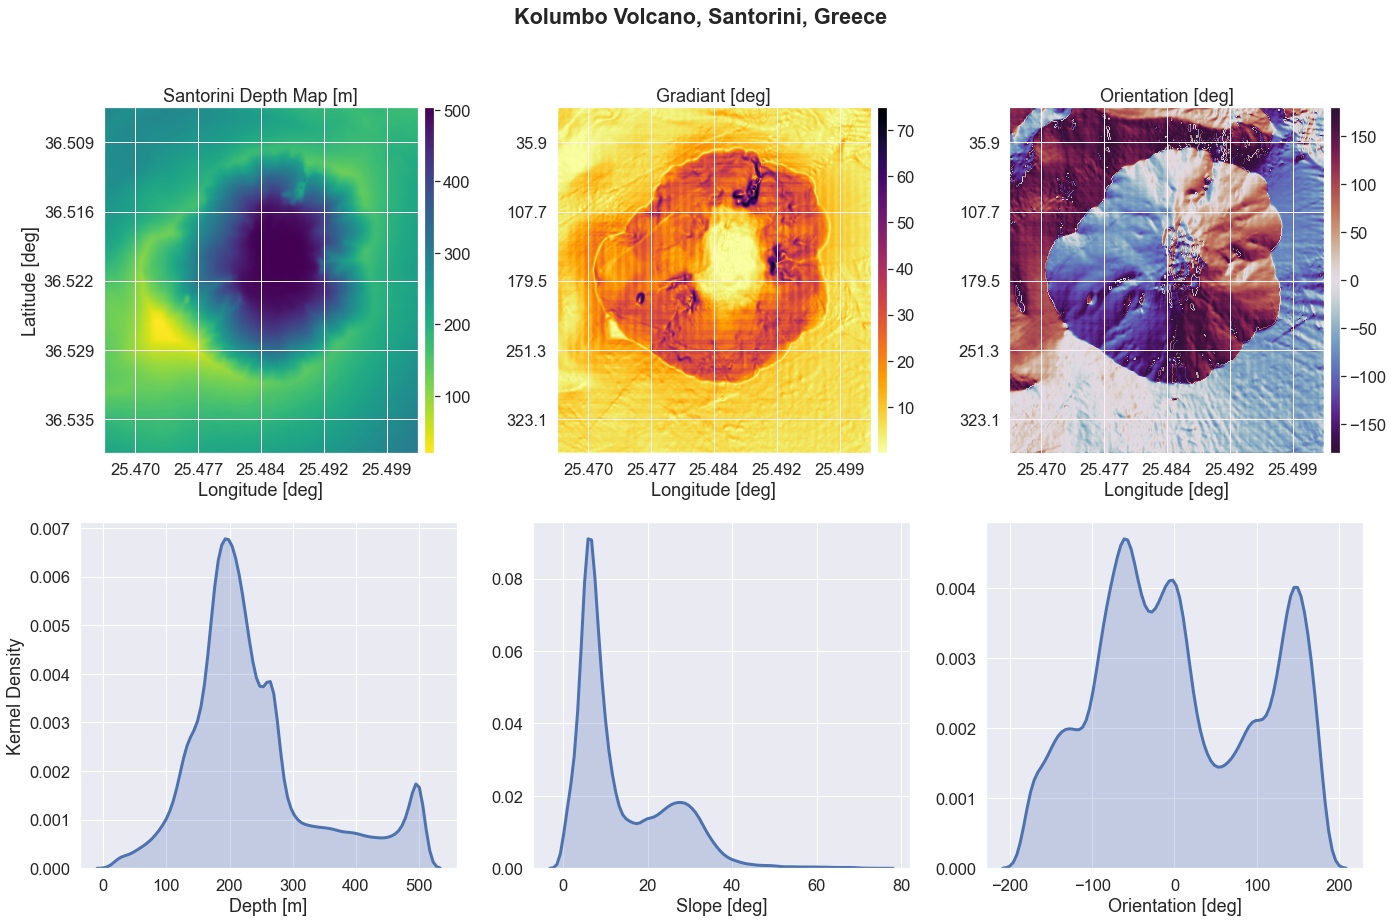

In [9]:
sns.set(font_scale = 1.5)
# fig, ax = plt.subplots(2,3, figsize=(23,6))
fig, ax = plt.subplots(2,3, figsize=(23,14))
plt.suptitle('Kolumbo Volcano, Santorini, Greece', fontweight='bold')


# plot seafloor depth
ep.plot_bands(
    -bathy, 
    cmap='viridis_r',
    title="Santorini Depth Map [m]",
    ax=ax[0,0],
    scale=False
)


# plot seafloor slope
ep.plot_bands(
    bathy_slope, 
    cmap='inferno_r',
    title='Gradiant [deg]',
    ax=ax[0,1],
    scale=False
)


# plot seafloor slope orientation 
ep.plot_bands(
    bathy_orient, 
    cmap='twilight_shifted',
    title='Orientation [deg]',
    ax=ax[0,2],
    scale=False
)


sns.kdeplot(-bathy.flatten(),       shade=True, ax=ax[1,0], linewidth=3)
sns.kdeplot(bathy_slope.flatten(),  shade=True, ax=ax[1,1], linewidth=3)
sns.kdeplot(bathy_orient.flatten(), shade=True, ax=ax[1,2], linewidth=3)
ax[1,0].set_xlabel('Depth [m]')
ax[1,1].set_xlabel('Slope [deg]')
ax[1,2].set_xlabel('Orientation [deg]')

# plt.savefig('/Users/zduguid/Desktop/fig/resize_bathy2.png')
num_ticks = 5
xticks  = np.arange(bathy_w/num_ticks/2, bathy_w, bathy_w/num_ticks)
xlabels = ['%.3f' % np.round((bathy_b.right-bathy_b.left)*(i/bathy_w) + bathy_b.left, 3) for i in xticks]
yticks  = np.arange(bathy_h/num_ticks/2, bathy_h, bathy_h/num_ticks)
ylabels = ['%.3f' % np.round((bathy_b.top-bathy_b.bottom)*(i/bathy_h) + bathy_b.bottom, 3) for i in yticks]


# plot axis labels 
for i in range(3):
    ax[0,i].set_xticks(xticks)
    ax[0,i].set_xticklabels(xlabels)
    ax[0,i].set_yticks(yticks)
    if i==0:
        ax[0,i].set_yticklabels(ylabels)
        ax[0,i].set_ylabel('Latitude [deg]')
        ax[1,i].set_ylabel('Kernel Density')
    ax[0,i].set_xlabel('Longitude [deg]')
    ax[0,i].grid(linewidth=1, alpha=1, color='lavenderblush')
# plt.savefig('/Users/zduguid/Desktop/fig/Kolumbo-bathy2.png')

plt.show()

